## 1. Import Library and define function 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

c:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def get_clf_eval(y_test, y_pred=None):
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['T[0]', 'F[1]'], columns = ['pred_T[0]', 'pred_F[1]'])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [3]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx + 1
    series = series.map(my_dict)

    return series

### 1.1 load data

In [4]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/submission.csv")
df_all = pd.concat([df_train, df_test], axis = 0)
df_all.shape, df_train.shape, df_test.shape

((64570, 30), (59299, 29), (5271, 30))

## 2. EDA & Data preprocessing

### 2.1 EDA

In [5]:
df_all.isnull().sum()

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate       48214
customer_idx                   0
customer_type              45418
enterprise                     0
historical_existing_cnt    49539
id_strategic_ver           60533
it_strategic_ver           63396
idit_strategic_ver         59359
customer_job               20172
lead_desc_length               0
inquiry_type                2233
product_category           21232
product_subcategory        54542
product_modelname          54779
customer_country.1           982
customer_position              0
response_corporate             0
expected_timeline          33271
ver_cus                        0
ver_pro                        0
ver_win_rate_x             43780
ver_win_ratio_per_bu       47360
business_area              43780
business_subarea           57228
lead_owner                     0
is_converted                5271
id                         59299
dtype: int

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64570 entries, 0 to 5270
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              64570 non-null  float64
 1   customer_country         63588 non-null  object 
 2   business_unit            64570 non-null  object 
 3   com_reg_ver_win_rate     16356 non-null  float64
 4   customer_idx             64570 non-null  int64  
 5   customer_type            19152 non-null  object 
 6   enterprise               64570 non-null  object 
 7   historical_existing_cnt  15031 non-null  float64
 8   id_strategic_ver         4037 non-null   float64
 9   it_strategic_ver         1174 non-null   float64
 10  idit_strategic_ver       5211 non-null   float64
 11  customer_job             44398 non-null  object 
 12  lead_desc_length         64570 non-null  int64  
 13  inquiry_type             62337 non-null  object 
 14  product_category         433

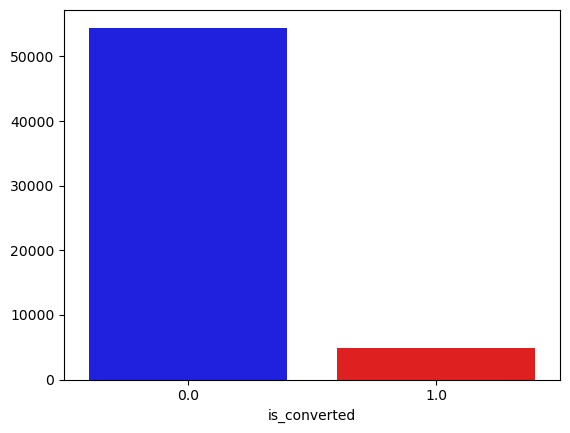

In [7]:
# 클래스 불균형이 심한 데이터
sns.barplot(x = df_all.is_converted.value_counts().index, y = df_all.is_converted.value_counts().values, palette = ['blue', 'red'])
plt.show()

In [8]:
df_all.is_converted.value_counts()

is_converted
0.0    54449
1.0     4850
Name: count, dtype: int64

범주형 변수 데이터 확인

In [9]:
df_all.customer_country.value_counts()

customer_country
//India                3055
/São Paulo/Brazil      1376
//United States        1122
//United Kingdom        807
//Saudi Arabia          719
                       ... 
/Bulandshahar/India       1
/india delhi/India        1
/gurugram /India          1
/Male' /U.A.E             1
/ Ongole  / India         1
Name: count, Length: 17480, dtype: int64

In [10]:
df_all.customer_type.value_counts()

customer_type
End-Customer                    6648
End Customer                    6449
Specifier/ Influencer           3313
Channel Partner                 1695
Service Partner                  447
Solution Eco-Partner             292
Installer/Contractor              52
Specifier / Influencer            43
Corporate                         31
HVAC Engineer                     23
Engineer                          20
Developer                         18
Technician                        16
Consultant                        15
Other                             10
Home Owner                        10
End-user                           8
Manager / Director                 8
Software/Solution Provider         7
Etc.                               6
Architect/Consultant               5
Homeowner                          5
Reseller                           5
Installer                          5
Interior Designer                  5
Distributor                        4
Others                  

In [11]:
df_all.customer_job.value_counts()

customer_job
engineering             7070
other                   4876
administrative          3666
education               2695
sales                   2380
                        ... 
appliance specialist       1
av estimator               1
purchasers                 1
pricing                    1
k12 school                 1
Name: count, Length: 562, dtype: int64

In [12]:
df_all.inquiry_type.value_counts()

inquiry_type
Quotation or purchase consultation                                                                                     23274
Quotation or Purchase Consultation                                                                                     22231
Sales Inquiry                                                                                                           9977
Product Information                                                                                                     1305
Other                                                                                                                    938
                                                                                                                       ...  
quotation_                                                                                                                 1
display product                                                                                                 

수치형 변수

<Axes: xlabel='bant_submit'>

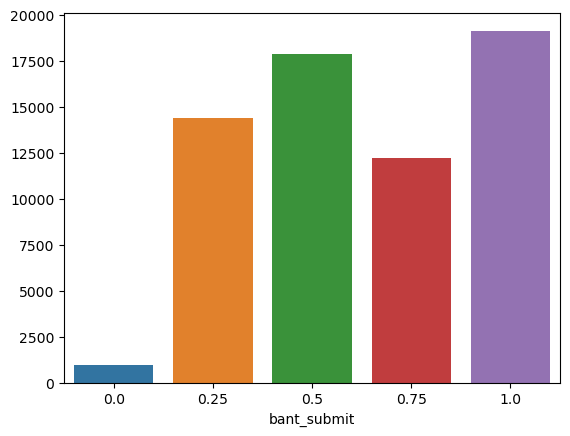

In [13]:
sns.barplot(x = df_all.bant_submit.value_counts().index, y = df_all.bant_submit.value_counts().values)

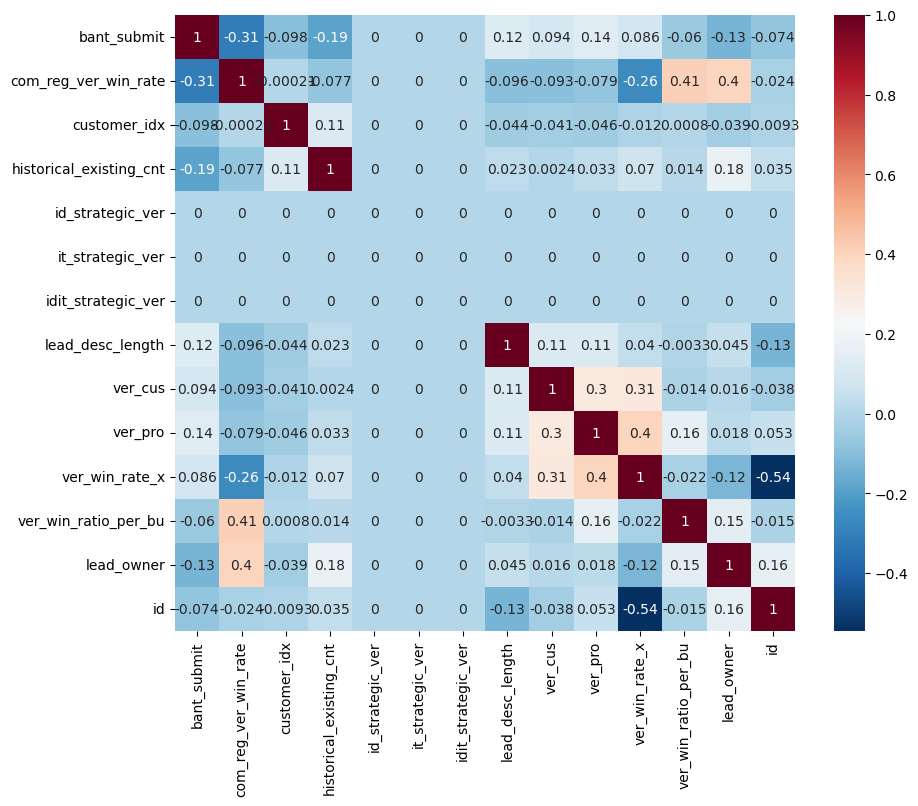

In [14]:
corr_mat = df_all.select_dtypes(include=['float64', 'int64']).corr().fillna(0)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot = True, cmap = 'RdBu_r')
plt.show()

### 2.1 drop columns

In [15]:
# 열 삭제
drop_col = ['customer_country.1', 'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver',
            'product_subcategory', 'product_modelname', 'business_area', 'business_subarea', 'ver_cus', 'ver_pro']

df_all.drop(columns = drop_col, inplace = True)

### 2.2 결측치 처리(수치형 데이터)

In [16]:
# 결측값 0으로 넣을 컬럼
fillna_col = ['com_reg_ver_win_rate', 'historical_existing_cnt',
             'ver_win_rate_x', 'ver_win_ratio_per_bu']

for col in fillna_col:
    df_all[col] = df_all[col].fillna(0)

In [17]:
df_all['customer_country'] = df_all['customer_country'].apply(lambda x: x.rsplit('/', 1)[-1].strip() if isinstance(x, str) else x)

In [18]:
df_all['customer_type'] = df_all['customer_type'].str.lower()
df_all['customer_type'] = df_all['customer_type'].replace(['etc.', 'other', 'others'], 'etc')
df_all['customer_type'] = df_all['customer_type'].replace(['end-customer', 'end customer', 'end-user'], 'end_user')
df_all['customer_type'] = df_all['customer_type'].replace(['specifier/ influencer', 'specifier / influencer'], 'influencer')
df_all['customer_type'] = df_all['customer_type'].replace(['homeowner', 'home owner'], 'home_owner')
df_all['customer_type'] = df_all['customer_type'].replace(['software/solution provider', 'software / solution provider'], 'solution_provider')
df_all['customer_type'] = df_all['customer_type'].replace(['engineer', 'hvac engineer'], 'engineer')
df_all['customer_type'] = df_all['customer_type'].replace(['distributor', 'dealer/distributor'], 'distributor')
df_all['customer_type'].fillna('none', inplace = True)

In [19]:
# value_counts 가 1개인 것들 etc로 분류
value_counts = df_all['customer_type'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_type'] = df_all['customer_type'].apply(lambda x: 'etc' if x in values_to_replace else x)

In [20]:
df_all['inquiry_type'] = df_all['inquiry_type'].str.lower()
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['etc.', 'other', 'other_', 'others'], 'etc')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['sales inquiry', 'sales', 'probeam precio'], 'sales inquiry')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['quotation or purchase consultation', 'request for quotation or purchase', 'quotation_or_purchase_consultation', 'purchase or quotation', 'quotation_', 'purchase'], 'quotation_or_purchase_consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['usage or technical consultation', 'technical consultation', 'request for technical consulting', 'usage_or_technical_consultation', 'technical_consultation', 'technical'], 'usage or technical consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['vui lòng báo giá giúp mình sản phẩm đo thân nhiệt xin cảm ơn', 'tôi cần tham khảo giá và giải pháp từ lg'], 'quotation_or_purchase_consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung'], 'product information')
df_all['inquiry_type'].fillna('none', inplace = True)

In [21]:
# value_counts 가 1개인 것들 etc로 분류
value_counts = df_all['inquiry_type'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['inquiry_type'] = df_all['inquiry_type'].apply(lambda x: 'etc' if x in values_to_replace else x)

In [22]:
# custoper_position 전처리
df_all['customer_position'] = df_all['customer_position'].replace(['ceo/founder', 'partner', 'vice president', 'c-level executive', 'director', 'vicepresident', 'c-levelexecutive', 'vp','leadership/executive office/owner', 'president'
                                                                   'principal & director', 'business partner', 'chairman', 'co-founder', 'chief executive officer', 'subsidiary sales (ise)', 'ceo/fundador', 'gerente', 'the big boss',
                                                                  'principal & director', 'president'], 'ceo')
df_all['customer_position'] = df_all['customer_position'].replace(['consultant', 'commercial consultant', 'architecture/consult', 'architect/consultant'], 'consult')
df_all['customer_position'] = df_all['customer_position'].replace(['customer', 'customer_position'], 'customer')
df_all['customer_position'] = df_all['customer_position'].replace(['decision-influencer', 'decision maker', 'decision influencer'], 'decision')
df_all['customer_position'] = df_all['customer_position'].replace(['distributor', 'cargo'], 'distributor')
df_all['customer_position'] = df_all['customer_position'].replace(['physics teacher','assistant professor','maths lecturer','science teacher','guest faculty','physics faculty','teacher/middle school coordinator','prof.',
                                                                   'academic specialist','principal at oxford integrated pu science college','math and physics teacher','professor of mathematics','physics and mathematics teacher',
                                                                   'assistant professor of english','educator','professor','quantitative aptitude faculty','english trainer for ielts,toefl,pte,gre,sat exams.','associate professor',
                                                                   'pgt physics','education professional','chemistry teacher','director cum faculty at gaining apex coaching centre','teacher','senior lecturer',
                                                                   'neet/ olympiad expert faculty','associate professor in electronics engg','education','pgt chemistry', 
                                                                   'academic coordinator/ post graduate teacher (accountancy, business studies)/ tgt (ict)','assistant professor of enlish'], 'education')
df_all['customer_position'] = df_all['customer_position'].replace(['entry level','intern','trainee','entrylevel','employee'], 'employee')

df_all['customer_position'] = df_all['customer_position'].replace(['exhibition','exhibitiontv'], 'exhibition')
df_all['customer_position'] = df_all['customer_position'].replace(['hospital', 'medical device manufacturer', 'medical imaging specialist', 'tierarzt', 'surgery professional', 'pathologist'], 'medical')
df_all['customer_position'] = df_all['customer_position'].replace(['not applicable','none','other','others'], 'etc')
df_all['customer_position'] = df_all['customer_position'].replace(['manager','associate/analyst','consulting','lider de desarrollo','decision-maker','business unit director','business development','operations',
                                                                   'product management','market intelligence/research'], 'pm')
df_all['customer_position'] = df_all['customer_position'].replace(['asst prof.','professional trainer','radiology professional'], 'professional')
df_all['customer_position'] = df_all['customer_position'].replace(['this is a consume display requirement for home purpose.','unpaid','homeowner','no influence'], 'unemployed')

In [23]:
# value_counts가 1인거 etc로 묶기
value_counts = df_all['customer_position'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_position'] = df_all['customer_position'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['customer_position'].fillna('none', inplace = True)

In [24]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64570 entries, 0 to 5270
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              64570 non-null  float64
 1   customer_country         63588 non-null  object 
 2   business_unit            64570 non-null  object 
 3   com_reg_ver_win_rate     64570 non-null  float64
 4   customer_idx             64570 non-null  int64  
 5   customer_type            64570 non-null  object 
 6   enterprise               64570 non-null  object 
 7   historical_existing_cnt  64570 non-null  float64
 8   customer_job             44398 non-null  object 
 9   lead_desc_length         64570 non-null  int64  
 10  inquiry_type             64570 non-null  object 
 11  product_category         43338 non-null  object 
 12  customer_position        64570 non-null  object 
 13  response_corporate       64570 non-null  object 
 14  expected_timeline        312

In [25]:
# 전처리 필요한 4개 컬럼 간단하게
value_counts = df_all['customer_job'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'other' if x in values_to_replace else x)
df_all['customer_job'].fillna('none', inplace = True)

value_counts = df_all['product_category'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['product_category'].fillna('none', inplace = True)

value_counts = df_all['customer_country'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_country'] = df_all['customer_country'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['customer_country'].fillna('none', inplace = True)

In [26]:
expected_timeline = df_all['expected_timeline']
expected_timeline = expected_timeline.str.replace('-', '')
expected_timeline = expected_timeline.str.replace('_', '')
expected_timeline = expected_timeline.str.replace('~', '')
expected_timeline = expected_timeline.str.replace(' ', '')
expected_timeline = expected_timeline.str.replace('.', '')
expected_timeline = expected_timeline.str.replace('etc', 'others')

In [27]:
sort_df = expected_timeline.fillna('none')

In [28]:
values = ['aggressivepricerequired',
       'alreadycloseinjulypurchsewithrd', 'alreadyconnectwithpartner',
       'alreadyindiscussionwithpartnerfrombangalore(kohinoor)andwithmr.indraneelfromcorporateoffice',
       'alreadyintouchwithcustomer',
       'alreadyintouchwithcustomerfromlast10days.droppingitbecausewearealreadyintouch',
       'alreadyintouchwithhimsincelong.hehasnotfinalizedyet.leadforwardedtord',
       'alreadyintouchwithpartner.', 'alreadyintouchwiththereteam',
       'alreadyourcustomer,havesharedpricesfornewrequirement',
       'alreadypurchasewithrd', 'alreadysharedquotationthroughsi.',
       'alreadytouchwithcustomerforkioskrequirement',
       'alreadytouchwithcustomers',
       'alreadyworkingonidbwillcreateopppostclarfyingonsignage',
       'alreadyworkingwithenduseronthisrequirement.',
       'askedtocallbacklater,ihadsharedthisleadwithrdtotakeitfurther.',
       'askedtocallbacktomorrow,ihadsharedthisenquirywithrd.',
       'askedtocallbacktomorrowmorning,notresponding',
       'askedtocalllater.','(selectidtimeline)', '09022022requestedforboqofrequirement',
       '14:0015:00',
       '14thaugaggressivepricerequiredashehasgotpricefromoutsidedelhi',
       '14thfeb2022shareddetails.awaitingupdatefromcustomer.',
       '25nov2021nomobilenumber,sentamailtocustomer',
       '29thsep2021:nosuchrequirementasofnow', '14thfeb2022shareddetailsawaitingupdatefromcustomer','alreadyintouchwithcustomerfromlast10daysdroppingitbecausewearealreadyintouch',
       'alreadyintouchwithhimsincelonghehasnotfinalizedyetleadforwardedtord',
       'alreadyintouchwithpartner', 'alreadysharedquotationthroughsi',
       'alreadyworkingwithenduseronthisrequirement',
       'askedtocallbacklater,ihadsharedthisleadwithrdtotakeitfurther','alreadyindiscussionwithpartnerfrombangalore(kohinoor)andwithmrindraneelfromcorporateoffice',
       'askedtocalllater', 'askedtocallon4thmay',
       'askedtocontacthimafter8thjan', 'askedtosenddetails',
       'askedtosharedetailsonmailhewillupdateifthereisanyrequirement',
       'assignedtopartnerintialmeetingdonewillconverttoopppostcompleteinfo',
       'atpresentnotrequired,', 'beingfollowedup',
       'bodeli,requirementpendingnewquotesendcloseinthismonthend',
       'budgetissue', 'budgetlowhenceclienthavenotwentahead',
       'budgetproblem', 'busy,calllater', 'busyneedtocallback',
       'callafter3june', 'callanddiscusednorequirement',
       'callanddiscusedtocustomecustomerwantsdemo',
       'callbackagainon30/04', 'callbacklater',
       'callbacklater,infirstweekmarch', 'calledtoknowthepriceofidb',
       'callnotconnecting', 'callnotpicking',
       'clienthaveseenthedemoheneededforbiggerroomandthecameraqualityandspeakertrackingwerethemainrequiredfeatureasofnow,hisbudgetisaround2lacsandneedbiggersizesolutionthereisnoresponsefromclientpostdemohenceclosing',
       'clientiscrosscheckingonpricesitsarccaseofsubwayandthefranchiseeistryingtogetpricingfromelsewhere',
       'clientisexploringhewilldiscussoncedetailssentdetailsmailedtohimasperrecentdiscussion,heisnotexploringasofnow',
       'clientislookingfor86"displaywithvcsolution,theywillgofordemonextweekanddecideonprocuringourtr3dj,detailssharedwithclientonmail',
       'clientisnothavinganyrequirement,hewasonlybrowsingthroughtheproduthenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'clientisnotlookingnowandhewasinterestedwithonlyinbuiltopsoptionhenceclosinginsystemasheisnotrespondingtocalls',
       'clientisnotrespondingcalls,followingupandkeeptheupdatetracked',
       'clientnotanweringcallsandaskedthereisnorequirementhewastryingtocheckpricesforone65touchrequirementofexistingclient',
       'clientnotinterestedinproductreceingcallandnotansweringproperly',
       'clientshallgetbackforexploringdemoofidb,postthattheywilldecideonprocuringthesame',
       'clientwasbusy,askedtocallbacklater,interestedinexploringouridb',
       'clientwasdrivingandaskedtocallbacklater,willfolloupandkeepposted',
       'clientwasexploringonproductsbuthedonthaveanyplanstopurchasecurrentlyhehaveholdedonhisrequirementandwillconnectifitreiniitaties',
       'clientwasinquiringforpricesalreadyquotedbyfewpartnerstheyevenpurchasedasperrecentupdatebutclienthasnotconfiermedpartnername',
       'clientwaskeentoexploreouridbsku,infollowup', 'cmsreqired',
       'communicationnumbernotavailable',
       'concernedpersonnotavailable,willcalllater',
       'conference/meetingroom/collaborationspaces',
       'connectedwithpartnerforstudiosetupwithcamera',
       'connectingforissue', 'connectwithpartner',
       'contactdetailsprovidedarewrong,sentmailforcorrectcontactdetails',
       'convertedthisleadintoopportunity', "couldn'tconect",
       "couldn'tconnect", 'couldntconnect',
       'customehasnotreceivecallason31stmayspokewithcustomer,hewillcomefordemoinnextweek14062022',
       'customepurchaseconsumerproduct', 'customerasktocallbacktomorrow',
       'customerbudgetis125+taxfor75inchidbihavegivenournoregretofferandalsoexplainedwhylgisbetterandpremiumhesaidhewillcomebackinadayortwo',
       'customergettingpricefromjaipurwhichlowthanouroperatingprice',
       'customerhasbeennotansweringcall', 'customerhasnotansweringcall',
       'customerhasnotansweringcall/customerwant86"interactivedisplay,hewillpurchasewithinnext6month,weareforwardingtolocalrdtotakethisfurther',
       'customerhasnotansweringcall/quotationhasbeensendtocustomer',
       'customerisbusyaskustocallagain,following',
       'customerislookingforresidential43inchdisplayforhomeuse',
       'customerneedshortthrowprojector',
       'customernotansweringcall,willcallhimagainandupdate',
       'customerphoneisgetsswitchedoff',
       'customerpurchasebenqforpricedifferance',
       'customervisitatuvbusinessandseethedemowithin2to3days',
       'customerwantdemoofidbhewillcomefordemoinnextweekafterfollowingupwithcustomermultipletimesthereisnoupdateleadhasbeenforwardedtord',
       'customerwantproductt15000',
       'customerwillbecomingfordemoon28thmaycustomerdidnotcamefordemoihaveshareddetailswithrdtotakeitfurtherhencedroppingthislead',
       'customerwillcomefordemoinnextweek,thanhewilldecidefurther',
       'december2022', 'delhienquirey', 'demoalignedforclient',
       'democompleted,customeraskedtocomefeb10thforclosure', 'demodone',
       'demodoneanddetailsshared',
       'demoplanned,willupdatefurtherstatusonceitscompleted',
       'demoscheduledfor24thoct', 'demoscheduledforfirstweekfeb',
       'demotobealigned', 'demotobeplanned',
       'detailsharedwithhimonemailheislookingforoneunitof65inchforhisconferenceroom',
       'detailssend', 'detailssendquoterequire', 'detailssendrequiredemo',
       'detailsshared', 'detailsshared,beingfollowedup',
       'detailsshared,toplandemoindecember',
       'detailssharedfollowupunderprogress',
       'detailssharedfor75tr,followupinfirstweekofoct',
       'detailssharedfuunderprogress',
       "detailssharedonwhatsapp,he'llrevertback",
       'detailssharedwithconcernpersonwillaskbdotofollowup',
       'detailssharedwithcustomer,alsoihadsharedleadwithrdtotakeitfurther',
       'detailssharedwithcustomer,hewillupdateonfurtheractionafterevaluatingotherbrandsaswell',
       'detailssharedwithcustomerason4thmaytriedmultipletimesbutnotreachable',
       'detailssharedwithcustomeronmai',
       'detailssharedwithcustomeronmail',
       'detailssharedwithpartnerhehasquotedinourexistingcustomeronly',
       'detailssharedwithrdforfurtheraction,',
       'dicsussedwithclient,detailssharedonmail,clienthavenobudgetstobuynowhenceclosinginthesystem',
       "didn'tpickupthecall", "didn'trespond", "didn'trespondtocalls",
       "dind'trespond", 'discusedwithankitindehli',
       'discussedandshareddetailswithclientfordigitalsignagetheyarenotplanningtopurchsethesamecurrentlyhenceclosinginthesystem',
       'discussedwithclient,detailsmailedforidbandonequick,theyhavenoplantobuyfornowhenceclosinginthesystem',
       'discussedwithclient,detailsmailedtheyarenotplanningtopurchasefornowhenceclosinginthesystem',
       'discussedwithclient,detailssharedonmailclienthavenopurchaseplansfornowhenceclosingthesameinsystem',
       'discussedwithclient,heshallsendthedetailsoftheirofficerequirement',
       'discussedwithclient,quotesent',
       'discussedwithclient,theywerejustevaluatingtheproduct,theyhavenoplanstobuythesame,henceclosinginthesystem',
       'discussedwithclientdemoalignedoncedone,willupdate',
       'discussedwithclientdetailsmailedclientdonthavebudgetforpurchasenowhenceclosinginthesystem',
       'discussedwithclientdetailsmailedforonequick,theyarenotplanningtobuythesamefornowhenceclosinginthesystem',
       'discussedwithclientdetailsmailedtheyhavebudgeissuefornowsotheywontbuyhenceclosinginyhesystem',
       'discussedwithclientdetailsmailedtoclientnobudgetsfornowwontbuyhenceclosinginthesystem',
       'discussedwithclienttheyarelookingforaiosolutionwithvctheywillcallafter20thforthedemoandthenpurchasethroughgem',
       'discussedwithclienttheyarenotevaluatuatingidbasofnow,theyhavenoplanstobuyhenceclosinginthesystem',
       'discussedwithclienttheyhavenobudgetsforpurchasefornow,theywontbuyhenceclosinginthesystem',
       'discussedwithclienttheyneed24inchdisplayfordigitalsignagementionedforouravailablesizes,heshallrevert',
       'discussedwithclienttheyneedforcsractivitypricesexpectationisverymuchlow',
       'discussedwithclientweneedtoaligndemotheexpectationisconnectingappledevicesbutnotmandatoryoncedemoisdone,weshallupdate',
       'discussedwithclientwillplanfordemo',
       'discussedwithpartnerheworkswithcloudwalkerandwantedtoconnectwithusforsomeproductdetailsasofnow,donthaveanyinquirytoworkandhenceclosinginsystem',
       'discussedwiththeclient,tr3bg&onequickworksdemoscheduledon27thjuly2022postdemotheywilldecideonprocuringtheunit',
       'discussedwiththeclientaskedtocallbackonmondaywillkeepafollowup',
       'discussedwiththeclienthedonthavebudgetsdetailsmailedhewontbuynowhenceclosinginthesystem',
       'discussedwiththeclientpricessharedforonequickandidbonmailcustomertoconfirmaboutdemooftheskuandfinaliseonprocurement',
       'discussedwiththeclienttheyareintererstedinourtr3djseriesdemoplannedfor29thjuneposttheywillplanonprocurementwillkeepupdate',
       'discussedwiththeclienttheypurchased65um3dffromthechannelunabletotrackthesupplierhenceclosinginthesystemmailsenttoclientforourdisplayrange',
       'discussiontobedonewithcustomer',
       'donthaveanyimmediaterequirementhemaypurchaseafterjune',
       'donthavebudgethewantdotled', 'don’thavebudget',
       'drop,alreadydonewithpartner',
       'drop,budgetproblemnowphonenotrespondig',
       'drop,lookongforconsumerproduct', 'drop,notintrested',
       'drop,nownotintrested',
       'drop,requirementofinteractivetouchscreentosupplyingovt,conncgtwithpartner',
       'drop,stillnoplanforpurchase', 'drop,wrongnumber',
       'dropnoplanforpurchase',
       'dropnotwillingtobuynowwilldoinfuturedetailssharedonwhatsap',
       'dropped,requiresdevicelikeonequicksharetobeusedwithsamsungtv',
       'droppedcontactnonotvalid', 'droppedhavepurchasedcloudwalker',
       'duetobudgetissue,customerhasboughtmaxhubpanel',
       'duetofinancialreasons,clienthavedroppedpurchaseplanalthoughthedetailsofidbaremailedtoclient',
       'duplicatelead',
       'duplicateleadil220100042906discussedwithclienttheirvchallisunderdevelopmentonequickdetailsmailedtoclienttheywillcallusfordemoandpurchasefinalizationoncetheirvcplaceisready',
         'emailsendfordetailsclientisexploringonsolutionsbutonlyfortheirundertanding',
       'existingcaseworkedbyourdisti,crewbusiness,henceclosingasclientisonlycheckingforcommercials',
       'existingpartner,discussedandaddressedtheconcernthepartnerhadtakenpricingandwantedtorecheckasthemodelquotedischanged',
       'exitingcustomer',
       'financeandaccountingconsultantinquiredfoe43inchaiobutdonthaveplanstobuydetailsdiscussed',
       'followingup', 'forwardedtoaurangabadrdforfurtherprocess',
       'forwardedtobdo,beingfollowedup', 'forwardedtobdotofollowup',
       'fuunderprogress','heaskedtosharebudgetoryquote,hewillcheckandconfirmifhewillrequiretheproduct',
       'heclientisnothavinganyrequirementhenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'hehasaskedtoconnectnextweekhewanttoseethephysicaldemo',
       'heisaneventorganizationandlookingforrentaldisplayshencedroppinginsystem',
       'heiscomparingwithsenseswhichislocalbrand',
       'heisindiscussioninternallyandwillupdate',
       'heislookingforaninteractivedisplaydiscussedwithclient,willupdateasthecaseprogress',
       'heislookingforconsumerproductforhome','heislookingforinteractivedisplayquotesharedwithhim',
       'heislookingforvideowall&idbforhisofficeourbdojayantisintouchwithhimandsharingtherequireddetailstocustomer',
       'heisrequestingdemoinaligarhup,plzsharetoupperson',
       'hejustneedbudgetorypricingwehavesharedthedetailswithhimandrequestedhimtocomefordemo',
       'heneedsforhomepurposeandisaconsumerclientspokeandguidedonthedetailsandchannelnotab2brequirement',
       'hewant32inchtvforsignagedetailssharedwithhim',
       'hewant65inchat50k', 'hewant98inchinbelow2lacs',
       'hewantdemoinaurangabad,detailssharedwithrd',
       'hewantdemoinlaturandalsodonthavemuchbudgetpartnerfollowedupmultipletimesbutnoresponse',
       'hewantdemoinsangli,ihaveloopedwithlocalpartner',
       'hewantphysicaldemooftr3bfinnashikbuttherebudgetisalsoverylowsofirsthewilldiscusswithmanagementonbudgetthenconfirmbackfordemo',
       'hewillcallbackifneeded', 'hisbudgetisunder50konly',
       'hisbudgetisverylow',
       'hisbudgetisverylowbutwearetryingtoconvincehimfor65inch',
       'idbdetaissend',
       'il220100042906repeatinquiryhenceclosingthisinsystem',
       'invalidlead',
       'isaninteriordesignerworkingonturnkeyprojectsmrbhuvneshisincontactandsharedspecsandprices',
       'itsbiharcustomer',
       'kinnarieletronisvatwahasbidforthesameandtheyaregoingtopurchasefromthem',
       'knownpartnerandalreadyworkingonacaseonlycrosscheckingpriceshencedropping',
       'knownpartnerandwehaveinstalled3videowallspanindiaforcctvwesupplied49vl5batrs62000andthenagain49vl5fatrs71000nowtheavailablemodelis49vl5gat80000+whichpartnerisrecheckingandhencemadeinquiryclosingtheinquirysi',
       'leadbelongstomaharashtra','lookingforactiveledinarangeof5lakhsnotaprospetivebuyer',
       'lookingforairconditioners',
       'lookingforcommercialtv55"detailsmailedtoclient,theyhavenoplansfornowtobuyhenceclosinginthesystem',
       'lookingforhomeuse',
       'lookingfornotmadeinchinaactiveoutdoorledforgovernmentproject',
       'lookingforoutdoordisplaycusotmerhasnoclarityonthesolutionemailsharedforunderstandingandwaitingforreply',
       'lowbudget', 'maileddetails&priceof55inches',
       'mayurelectronicconnectwithclient', 'meetingdatetobefinalised',
       'meetingplannedforfurtherdiscussion','mobileisswitchedofftried3times','mrrajnikantisallignwiththeclient',
       'needforhomesegmenttheypurchasedvu85inchtvfortheirhome',
       'needtoarrangequoteanddemo', 'needtododomestictradebiz',
       'nextweekhewillcomefordemoatlgoffice',
       'nocontactnumber,ihavedroppedaemailrequestingforthesame',
       'nodropthislead,nobudget!',
       'nofurtherrevert&clarityaftersharingdetails', 'noreqirements',
       'norequirement', 'norequirementofthistime', 'noresponse',
       'noresponseonmailsfromtheclientcouldntfindanycontactdetailsonnetaswellhencedroppinginthesystemalthoughidbandonequickdetailssharedonemail',
       'notansweringcall', 'notansweringcall,detailssharedwithrd',
       'notansweringcall,leadsharedwithrd',
       'notansweringcall,salesremarks:triedtoreachhimmultipletimesbutheisnotrespondingrequesttoshailjatoreconnectwithcustomerwearedroppingthisleadfornow',
       'notansweringcall,sharedleadwithrd',
       'notansweringcall,willtrytoreachhimagain',
       'notansweringcall|ason11thjunecustomerphoneisnotreachableiamdroppingthisleadandforwardingtopartner',
       'notansweringtriedseveraltimesdetailssharedwithrd',
       'notinterested', 'notinterestedatthemoment',
       'notinterestedincommercialtvs', 'notlifted', 'notlifted,calllater',
       'notpickingcalls,calledmanytimes', 'notreachable',
       'notreachable,detailssharedwithrd',
       'notreachable,ihadsharedleadwithpartner',
       'notreachable,leadsharedwithpartner', 'notrequire', 'notrequired',
       'notrequirednow', 'notresponding',
       'notresponding,detailssharedwithlocalrd', 'notrespondingtocalls',
       'notrespondingtriedmanytimes', 'november2022', 'november22',
       'october2022','ordertaken',
       'ourpartner,visnetworksisworkingonthisinquiryandclientiscrosscheckingthepriceshenceclosinginthesystem',
       'partnerisalreadyintouchwithourrd,ornothepartnerneedstocrosscheckontheinformationasthesizeischangedfrom49to50nowclosingtheopprtunityasitsexistingwithrd',
       'partnerisintostaticsignagesheneedtoconnectfordigitalsignagebuthehimselfismanufactureralthoughamailinitaitedforanyrequirementswithledteamtotakeitaheadasofnow,thereisnoscopehenceclosinginsystem',
       "partnerisworkingonexistingrequirementheisconnectedwithourdisti'sforbilling",
       'partnerwasexploringoneolmodelforsomerequiremeentnodesignatedsalesorclosureexpectedhenceclosinginthesystem',
       'phonenumbernotavailable', 'phoneswtichedoff', 'priceshared',
       'pricesharedwithcustomerheislookingforsomeidbsneedtotakefollowup',
       'pricesharewithcustomerourrdisfollowingupwithhimbutcustomerisnotresponding',
       'projectcancle',
       'proposalsubmitted,duetocovidmdisnotcomintoofficeforthemeeting',
       'providedmodelandpriceasperrequirement',
       'purchasedfrombinary@123l', 'purchasedsomelocalpanel,budgetissue',
       'purchasedviewsonicpanel','purchasevubrand',
       'quotationsent–75tr3dj,workinprogress,hewillbuyafter2monthshehasnotevenseenthequoteyet',
       'quotationshared',
       'quotationsharedforultrastrothershand49vl5ghewillcheckwithmanagementandupdateus',
       'quotationsharedincommunication', 'quotationsharedwithcustomer',
       'quotationsharedwithcustomer,hewillconfirmbackafterdiscussingwithmanagement09062022asontoday14062022notansweringcallhenceiamdroppingthisleaddetailsshredwithrdtakeitforfurther',
       'quotationsharedwithhimforidbhedonthaveenoughfundasofnowheisjustevaluatingoptions',
       'quotehasbeensenttocustomer', 'quotesend',
       'quotesendmeetingpending', 'quotesendnextmonthrequire',
       'quotesendrequiredemo', 'quotesendrequiredemoinnextweek',
       'quotesent,theclientisrequireddemoinjune', 'quotesenttocustomer',
       'quotesharedbuttherebudgetisverylow',
       'quotesharedfor86inchheisevaluationlocalbrandoftrueview',
       'quotesharedwithcustomer,hewillconfirmafter2monthsleadsharedwithpartner',
       'quotesharedwithcustomer,leadsharedwithpartnertotakeitfurther',
       'quotesharedwithcustomerhewillrevertwithanupdate',
       'quotesharedwithhim',
       'quotesharedwithhimandhewillupdateusafterdemo',
       'rajnikantisworkinginthiscasehoinahmedabadanditsunderprocess',
       'receivedpo', 'recentlynorequirement,dropped',
       'remarks:customerlookingfor65inchesand75incheseach1qty',
       'repeatedinquiryfromclienthewasjustinquiringbuthavenotconfimredonpurchasewehavetriedmulitpletimesbutclientisnotinterestedinbuying',
       'repeatenquiry',
       'repeatinquiry,wealreadyknewontheclientrequirementweareintouchwiththemandifanyrequirementcomes,wewilludpateasofnow,thetransparentledtheyneedisnotavailablewithusandtheavailableproductcostexpectationisverylowwit',
       'require65inchidbunder80k', 'requiredemo', 'requiredemoafter20may',
       'requiredemopricesend',
       'requirementisforpuneloopedpuneteamalthoughthepartnerischeckingpricesforanexistingcaseclosingtheleadinsystemaspuneteamisalreadyworking',
       'requirementof65tr3dj',
       'requirementof65tr3djandcustomerwantdemo,detailssharedwithrd',
       'requirementof65tr3dj–demoreqired,leadsharedwithrd',
       'requirementof65tr3dj–demorequired',
       'requirementof75tr3dj–demo,detailssharedwithrd',
       'requirementof75tr3dj–demo,leadsharedwithmumbaiteam',
       'requirementof75tr3dj–demorequired',
       'requirementofidb,budgetisverylowshareddetailsonwhatsapp1unitrequiredrdisfollowingup',
       'requirementofvideowallclientischekingonpricesalready2partnersworkingitsongoingcasehenceclisinginsystem',
       'requireonlycmssoftware', 'requirequote',
       'requiresdetailfortendernopurchaserequirementrightnow',
       'resellerwanttohavegemauthorization',
       'reuiredforofficeaskedtosharequotation', 'rnr',
       'sameasleadnoil220300046498hencedroppingduplicatelead',
       'schedulingameeting', 'september', 'september2022',
       'sizenotavailable', 'smallsizetabrequired',
       'spokentoclient,hewillcheckiftheyneeddemoandconfirm',
       'spokentoclient,hewillconnectoncehediscussonrequirement',
       'spokentopartner,havenoanyrequierementsfornow,havemailedthedetailstohim,hewontpurchaseanyskusfornowhenceclosinginthesystem',
       'spokewithcustomehewant43"tv',
       'spokewithcustomer,detailsneedstoshareonmailalsotheywantdemo',
       'spokewithcustomer,heislookingfordotledproductin42inch,ihavesuggestedhimour43inchsignagebuthewantfullyoutdoorledihavesharedthedetailsofour43inchdisplay',
       'spokewithcustomer,willbesharingdetailsonemail',
       'spokewithherandsharedthedetailsforsignagedisplays','theclientbudgetiswithin1lacstheyneed55inchaiosolutionasperdiscussion,theyarecomparingwithjabraandweproposedtocheckiftheyneedonlydisplaysbutduetobudgothersontraint,theyaredroppingtheidea',
       'theclientislookingforsmallsizedisplaysof20inchto25inchtomountonrefthebudgetis4kto6knotexactlyourrequirement',
       'theclientisnothavinganyrequirement,hewasonlybrowsingthroughtheproduthenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'theclientisnothavinganyrequirement,shewasonlybrowsingthroughtheproduthenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'theclientisnothavinganyrequirementhenceclosiginsystemalthoughthedetailsofidbaremailedtoclient',
       'theclientisnothavinganyrequirementhewasjustbrowsingforproductshenceclosiginsystemalthoughthedetailsofidbandvideowallsaremailedtoclient',
       'thepartnerischeckingpriceforanongoingcaseofbarcwehavediscussedonnewcasewiththepartneritsusefultotakeourdiscussionfurtherfornewinquriesclosingtheopportunityinsystemasofnowasitsmadeonlyforcrosscheckingprices',
       'thererquirementisforpuneemailedclientloopingpuneteamtomeetandvisittheclient',
       'theyareconsultantandiamalreadyintouchwithcustomer',
       'theyarehavingrequirementof40displayscustomerneedaggressivepricingthansamsung',
       'treidmanytimesbutphonenotreachable',
       'triedcallingtheclient,noresponsefromclient,ihavemailedidbdetails,willkeepfollowup&update',
       "triedcontacthimbutcouldn'tabletoconnectleadforwardedtord",
       'triedcoupleoftimesbutheisnotrespondingwewilltryagain',
       'triedreachingouttoclientnoresponsetocalllssoihavesharedthedatasheet,shalllfolllllowupandupdate',
       'triedtoreachcustomerbutnoresponseleadforwardedtopartnerforfurtherfollowup',
       'triedtoreachhimbutnoresponseiwillcallhimagain18thnovicalledhimagainandhewillsendtherequirementonmail',
       "triedtoreachhimmultipetimesfromlast7daysbutcouldn'tgetthrough",
       "triedtoreachhimmultipletimes,butcouldn'tgetthru",
       'triedtoreachseveraltimesbutnoresponse', 'underdiscussion','uttarpradeshstatelead',
       'veryabruptcustomersaidtheinquirywasmademonthsagoandwasrudeenoughclosinginthesystemastheclientbehaviourhasnoscopetodiscussonrequirementneedmarketingteamtocheckifthecasewasreceivedindecorjanasperclient',
       'wanttodotradeproductbusiness', 'wanttotakeretailmonitor',
       'wearealreadyintouchwithcustomerthrupartner',
       'wearealreadyintouchwiththiscutsomerfromlast2years,hehasneverpurchasedanyproducttilldateicalledhimuptwicebutnoreponse',
       'wearenotgoingtomatchtechnicalspecification',
       'wehavepitched110inchfuunderprgress',
       'wewerealreadyworkinghere,wearefacingchallengeaswedonthave49vl5ginstockorderlostinmarchduetounavailabiltyof49vl5g',
       'willcomebackonceitisrequired', 'willcomeforthedemo',
       'withdrawnthedecissiontopurchase', 'últimarevisión:26/07/21','underdiscussion,requirementnotdinalisedyet',
       'update14thseptmoredetailstobesharedbyclient',
       'updateaspercustomernoenquirywasmade',
       'updatedetailsalreadysharedwithcustomerevaluationisongoing','uptodecember']

sort_df = sort_df.apply(lambda x: 'others' if x in values else x)
sort_df = sort_df.replace('callbacktomorrow28/09', 'lessthan3months')
sort_df = sort_df.replace('then', 'than')
len(sort_df.unique())

42

In [29]:
values = ['lessthan3months,meetingwiththecustomerforthemoredetailsandtentativeboqwillne32and43',
       'lessthan3monthscustomernotansweredtocallback',
       'lessthan3monthsoutdoorledrequiment', '4/8months', '45days', 'askedtocallbacktomorrow',
          'askedtocallnextweek','askedtocallbacktomorrow,ihadsharedthisenquirywithrd',
         'duplicateleadil220100042906lessthan3months', 'eolmodelnewmodelquoterequirmentafter30days',
         'getbackin1wk','heislookingfordisplayforhisrestauranthehasaskedtocontacthimafter1monthasrestaurantworkisunderprogress',
        'hewantdemonextmonthatpune15may', 'hewantdemonextweek','needtodiscusswithclientinnexttwomonthstheyneedtochecktheproductandaccridnglyproceedforpersonaluse'
          ,'meetingplannednextweek','needtocallonfriday27th', 'onemonth', 'spokewithshubhamwhoisstudenthesaidhewillspeakwithhissirandrevertbackafter2weeks', '3months',
         'update14thseptcustomerwilldiscussindetailtomorrow','update13thspetfollowuptobedoneon15thsept', 'update27thaugcustomerhastocomeforproductdemo',
       'update4thaugcustomeraskedtocallonmonday',
       'update4thaugcustomervisitingexperiencecentreon8thsept',
       'update4thaugdetaileddiscussiontobedoneon6thaug',
       'update7thaugdemogivencustomerwillconfirmnextweek',
       'update8thseptdetailssharedwillconfirmdemoscheduleofnextweek',
       'update9thoctdetailssharedwillconfirmforonlinedemonextweek', 'updatecalltobemadeontuesday',]

sort_df = sort_df.apply(lambda x: 'lessthan3months' if x in values else x)

In [30]:
sort_df = sort_df.replace('lessthen6months', 'lessthan6months')
sort_df = sort_df.replace('lessthan5months', 'lessthan6months')
sort_df = sort_df.replace('morethen3months', 'lessthan6months')
sort_df = sort_df.replace('needshoteltvafter4months,willcallus', 'lessthan6months')
sort_df = sort_df.replace('purchaseplanningafter3months', 'lessthan6months')
sort_df = sort_df.replace('lessthan6months', '3months6months')

In [31]:
df_all['expected_timeline'] = sort_df

In [32]:
df_all['expected_timeline'].unique()

array(['lessthan3months', 'none', '3months6months', '9months1year',
       'morethanayear', '6months9months', 'others'], dtype=object)

In [33]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64570 entries, 0 to 5270
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              64570 non-null  float64
 1   customer_country         64570 non-null  object 
 2   business_unit            64570 non-null  object 
 3   com_reg_ver_win_rate     64570 non-null  float64
 4   customer_idx             64570 non-null  int64  
 5   customer_type            64570 non-null  object 
 6   enterprise               64570 non-null  object 
 7   historical_existing_cnt  64570 non-null  float64
 8   customer_job             64570 non-null  object 
 9   lead_desc_length         64570 non-null  int64  
 10  inquiry_type             64570 non-null  object 
 11  product_category         64570 non-null  object 
 12  customer_position        64570 non-null  object 
 13  response_corporate       64570 non-null  object 
 14  expected_timeline        645

In [34]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

In [35]:
df_train = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):]

In [36]:
df_train.is_converted.value_counts()

is_converted
0.0    54449
1.0     4850
Name: count, dtype: int64

In [37]:
df_train[df_train['customer_idx'] == 25096]['is_converted'].value_counts()

is_converted
1.0    2421
Name: count, dtype: int64

In [39]:
df_test[df_test['customer_idx'] == 25096]

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,inquiry_type,product_category,customer_position,response_corporate,expected_timeline,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner,is_converted,id


In [172]:
sample = df_train[df_train['customer_idx'] == 25096].sample(100, random_state=42)
# df_train = df_train[df_train['customer_idx'] != 25096]
df_train = pd.concat([df_train[df_train['customer_idx'] != 25096], sample])

In [173]:
df_true = df_train[df_train['is_converted'] == True] # 2529
df_false = df_train[df_train['is_converted'] == False] # 54449

In [174]:
from sklearn.utils import shuffle
df_false = shuffle(df_false, random_state = 42)

In [175]:
ratio = df_false.shape[0] // 20

df_f0 = df_false.iloc[ratio*0:ratio*1]
df_f1 = df_false.iloc[ratio*1:ratio*2]
df_f2 = df_false.iloc[ratio*2:ratio*3]
df_f3 = df_false.iloc[ratio*3:ratio*4]
df_f4 = df_false.iloc[ratio*4:ratio*5]
df_f5 = df_false.iloc[ratio*5:ratio*6]
df_f6 = df_false.iloc[ratio*6:ratio*7]
df_f7 = df_false.iloc[ratio*7:ratio*8]
df_f8 = df_false.iloc[ratio*8:ratio*9]
df_f9 = df_false.iloc[ratio*9:ratio*10]
df_f10 = df_false.iloc[ratio*10:ratio*11]
df_f11 = df_false.iloc[ratio*11:ratio*12]
df_f12 = df_false.iloc[ratio*12:ratio*13]
df_f13 = df_false.iloc[ratio*13:ratio*14]
df_f14 = df_false.iloc[ratio*14:ratio*15]
df_f15 = df_false.iloc[ratio*15:ratio*16]
df_f16 = df_false.iloc[ratio*16:ratio*17]
df_f17 = df_false.iloc[ratio*17:ratio*18]
df_f18 = df_false.iloc[ratio*18:ratio*19]
df_f19 = df_false.iloc[ratio*19:]

In [176]:
df_train = pd.concat([df_true, df_f0])

In [177]:
df_train.shape, df_train['is_converted'].sum()

((5251, 20), 2529.0)

In [178]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop(["is_converted", 'id'], axis=1),
    df_train["is_converted"].astype(int),
    test_size=0.2,
    random_state=42,
)

In [179]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

### xgb

In [ ]:
xgb = XGBClassifier(random_state=42)
param_grid = {'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800], 'learning_rate' : np.arange(0.01, 0.15, 0.02),
             'subsample' : [0.8], 'colsample_bytree' : [0.8]}

grid_xgb = GridSearchCV(xgb, param_grid, verbose = True, scoring='f1')
grid_xgb.fit(x_train, y_train)

print('최적의 파라미터 :', grid_xgb.best_params_)

In [ ]:
y_pred = grid_xgb.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_xgb.predict(x_test)
sum(test_pred), len(test_pred) # True로 예측된 개수

### gb

In [48]:
gb = GradientBoostingClassifier(random_state=42)
param_grid = {'n_estimators': np.arange(500, 1501, 100), 'learning_rate': np.arange(0.01, 0.15, 0.02),
              'subsample': [0.8], 'max_features': [0.8]}

grid_gb = GridSearchCV(gb, param_grid, verbose=True, scoring='f1')
grid_gb.fit(x_train, y_train)

print('최적의 파라미터 :', grid_gb.best_params_)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
최적의 파라미터 : {'learning_rate': 0.049999999999999996, 'max_features': 0.8, 'n_estimators': 1100, 'subsample': 0.8}


In [49]:
y_pred = grid_gb.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_gb.predict(x_test)
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        471         53
F[1]         42        485

정확도: 0.9096
정밀도: 0.9015
재현율: 0.9203
F1: 0.9108


(2234, 5271)

### random forest

In [43]:
rf_clf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators' : np.arange(10, 201, 10),  'max_samples' : [0.8], 
              'max_features' : [0.8], 'criterion' : ["entropy"]}

grid_rf_clf = GridSearchCV(rf_clf, param_grid, verbose = True, scoring='f1')
grid_rf_clf.fit(x_train, y_train)

print('최적의 파라미터 :', grid_rf_clf.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
최적의 파라미터 : {'criterion': 'entropy', 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 120}


In [44]:
y_pred = grid_rf_clf.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_rf_clf.predict(x_test)
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        467         57
F[1]         44        483

정확도: 0.9039
정밀도: 0.8944
재현율: 0.9165
F1: 0.9053


(2411, 5271)

In [232]:
cat = CatBoostClassifier(random_state=42, verbose = False, colsample_bylevel = 0.8, 
                         iterations = 1500, learning_rate = 0.05, subsample = 0.8)
cat.fit(x_train, y_train.astype(int))

lgbm = LGBMClassifier(random_state = 42, verbose = 0, colsample_bytree = 0.8,
                      learning_rate = 0.05, n_estimators = 300, subsample = 0.8)
lgbm.fit(x_train, y_train)

xgb = XGBClassifier(random_state=42, colsample_bytree = 0.8, n_estimators = 600, 
                    learning_rate = 0.05, subsample = 0.8)
xgb.fit(x_train, y_train)

gb = GradientBoostingClassifier(random_state=42, n_estimators = 1100,
                                learning_rate = 0.05, subsample = 0.8, max_features = 0.8)
gb.fit(x_train, y_train)

rf_clf = RandomForestClassifier(random_state=42, max_features = 0.8, max_samples = 0.8, 
                                criterion = 'entropy', n_estimators = 120)
rf_clf.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=300,
               random_state=42, subsample=0.8, verbose=0)

In [233]:
vote = VotingClassifier(estimators= [('cat', cat), ('lgbm', lgbm), ('xgb', xgb), ('gb', gb), ('rf_clf', rf_clf)], voting= 'soft')
vote.fit(x_train, y_train)

y_pred = vote.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = vote.predict(x_test)
sum(test_pred), len(test_pred)

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        481         47
F[1]         38        486

정확도: 0.9192
정밀도: 0.9118
재현율: 0.9275
F1: 0.9196


(2224, 5271)

In [181]:
test_pred = vote.predict_proba(x_test)
total_test = pd.DataFrame() # 처음에만 실햄
total_test = pd.concat([total_test, pd.DataFrame(test_pred)], axis = 1)
total_test.to_csv('7-13test.csv', index = 0)

,0,1,0.1,1.1,0.2,1.2,0.3,1.3,0.4,1.4,0.5,1.5,0.6,1.6,0.7,1.7,0.8,1.8
0,0.510936,0.489064,0.455467,0.544533,0.215536,0.784464,0.611111,0.388889,0.486318,0.513682,0.535831,0.464169,0.232675,0.767325,0.236869,0.763131,0.631611,0.368389
1,0.022331,0.977669,0.011720,0.988280,0.035872,0.964128,0.007557,0.992443,0.011549,0.988451,0.013125,0.986875,0.016687,0.983313,0.040393,0.959607,0.031382,0.968618
2,0.125976,0.874024,0.559110,0.440890,0.625297,0.374703,0.691098,0.308902,0.477955,0.522045,0.825367,0.174633,0.721736,0.278264,0.431879,0.568121,0.344371,0.655629
3,0.977989,0.022011,0.916201,0.083799,0.975953,0.024047,0.965181,0.034819,0.966935,0.033065,0.994354,0.005646,0.985996,0.014004,0.986199,0.013801,0.976922,0.023078
4,0.068046,0.931954,0.019060,0.980940,0.046455,0.953545,0.150941,0.849059,0.097473,0.902527,0.016263,0.983737,0.032257,0.967743,0.055927,0.944073,0.127429,0.872571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.996729,0.003271,0.997648,0.002352,0.995534,0.004466,0.996378,0.003622,0.990421,0.009579,0.994426,0.005574,0.997327,0.002673,0.994056,0.005944,0.989835,0.010165
5267,0.075165,0.924835,0.130636,0.869364,0.029050,0.970950,0.062530,0.937470,0.149563,0.850437,0.032722,0.967278,0.095281,0.904719,0.076632,0.923368,0.045403,0.954597
5268,0.984941,0.015059,0.983316,0.016684,0.986923,0.013077,0.971804,0.028196,0.983740,0.016260,0.979821,0.020179,0.978366,0.021634,0.979370,0.020630,0.973150,0.026850
5269,0.310115,0.689885,0.358750,0.641250,0.131582,0.868418,0.382971,0.617029,0.391356,0.608644,0.668245,0.331755,0.304421,0.695579,0.181285,0.818715,0.355245,0.644755


In [188]:
ff = total_test.iloc[:, ::2].mean(axis = 1)
tt = total_test.iloc[:, 1::2].mean(axis = 1)

result = []
for i in range(len(ff)):
    if ff[i] > tt[i]:
        result.append(0)
    elif ff[i] < tt[i]:
        result.append(1)
        
result = np.array(result)

In [356]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = result

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)